In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%cd /content/drive/MyDrive/Skin_cancer_NN

[WinError 3] Системе не удается найти указанный путь: '/content/drive/MyDrive/Skin_cancer_NN'
C:\Users\shari\PycharmProjects\Cancer_Classification


In [3]:
import torch
import torch.nn as nn
from ModelSelection import Net
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [5]:
def acc_loss_one_epoch(X_test_batch, Y_test_batch, NN_Model, criterion, device='cuda'):
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    pred = NN_Model(X_test_batch)
    preds = torch.argmax(pred, dim=1)
    true_preds = torch.argmax(Y_test_batch, dim=1)
    acc = (preds == true_preds).cpu().numpy().mean()
    pred = pred.to(device)
    loss = criterion(pred, Y_test_batch)
    return acc, loss.to('cpu')

In [6]:
X = np.load('X_preprocessed.npy')
Y = np.load('Y_preprocessed.npy')
X = X.swapaxes(1, 2)
X = X.swapaxes(1, 3)
X.shape

(3500, 3, 64, 64)

In [7]:
X = torch.tensor(X, dtype = torch.float32)
Y = torch.tensor(Y, dtype = torch.float32)

In [8]:
print(X.shape)
X = X.view(3500, 3, 64, 64)

torch.Size([3500, 3, 64, 64])


In [9]:
Y.shape

torch.Size([3500, 7])

In [10]:
Y

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [11]:
ConvNet = Net().to(device)

In [35]:
history_loss = []
history_val_loss = []
history_accuracy = []
early_stop = 50
epochs = 500
batch_size = 128
lr = 0.0001

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNet.parameters(), lr = lr)

In [14]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, shuffle = True)

In [22]:
X_test_batch = X_test[:batch_size, :, :, :]
Y_test_batch = Y_test[:batch_size, :]

In [16]:
from MyBatchCreator import DataLoader

In [17]:
data_loader = DataLoader(X_train, Y_train, batch_size = batch_size)
data_loader

<generator object DataLoader at 0x000001E65F68E900>

In [18]:
X_train.shape[0]

2800

In [19]:
device

'cuda'

In [36]:
early_stopper = EarlyStopper(patience = early_stop)

In [23]:
for epoch in tqdm(range(epochs)):

    running_loss = 0.0
    data_loader = DataLoader(X_train, Y_train, batch_size = batch_size)

    for batch in data_loader:
        X_batch, Y_batch = batch
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()

        Y_pred = ConvNet(X_batch)
        Y_pred = Y_pred.to(device)

        loss = criterion(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.to('cpu')
        running_loss += loss.item()

    history_loss.append(running_loss / batch_size)
    with torch.no_grad():
      accuracy, val_loss = acc_loss_one_epoch(X_test_batch, Y_test_batch, ConvNet, criterion)
      history_val_loss.append(val_loss)
      history_accuracy.append(accuracy)
      if early_stopper.early_stop(val_loss):
          break
      torch.cuda.empty_cache()
print('Train is over')

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

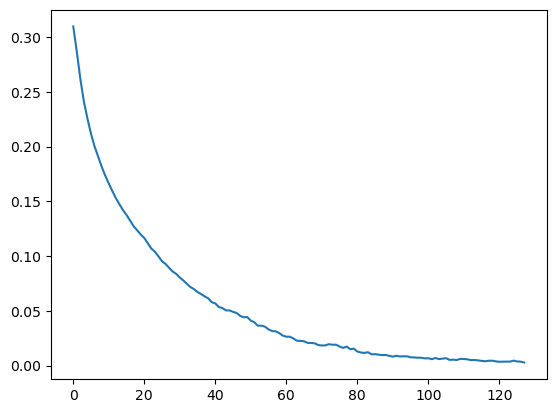

In [24]:
plt.plot(history_loss)

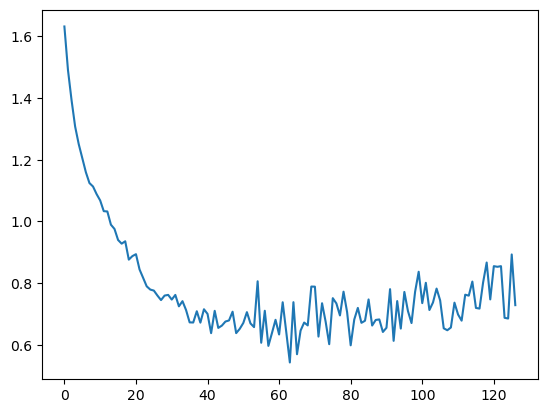

In [25]:
plt.plot(history_val_loss)

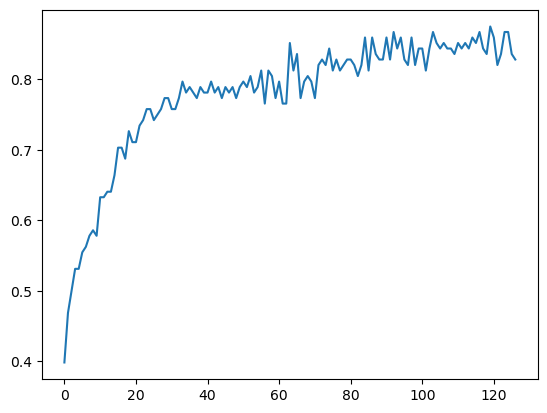

In [26]:
plt.plot(history_accuracy)

In [27]:
torch.cuda.empty_cache()

In [29]:
max(history_accuracy)

0.875

In [30]:
acc = 0
batches = 0

In [31]:
test_data_loader = DataLoader(X_test, Y_test, batch_size = batch_size)

In [33]:
ConvNet.to('cpu')

Net(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=2304, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=50, bias=True)
  (lin3): Linear(in_features=50, out_features=20, bias=True)
  (lin4): Linear(in_features=20, out_features=7, bias=True)
)

In [34]:
for batch in test_data_loader:
    X_test_batch, Y_test_batch = batch
    X_test_batch = X_test_batch.to('cpu')
    Y_test_batch = Y_test_batch.to('cpu')
    
    pred = ConvNet(X_test_batch)
    preds = torch.argmax(pred, dim=1)
    true_preds = torch.argmax(Y_test_batch, dim=1)
    acc += (preds == true_preds).cpu().numpy().mean()
    batches += 1
print(f'Final accuracy: {acc / batches}%')

Final accuracy: 0.814453125%


In [37]:
torch.cuda.empty_cache()

In [39]:
pytorch_total_params = sum(p.numel() for p in ConvNet.parameters())

In [40]:
pytorch_total_params

660713